# Acoustic Experiments

## Imports

In [15]:
# Python Standard Library
import getopt
import os
import sys
import math
import time
import collections
import random

# IPython
from IPython.display import display

# pandas
import pandas as pd
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt                       
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator

# seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

# NumPy
import numpy as np                                    

# SciPy
import scipy as sp
from scipy.io import wavfile
from scipy import signal
from scipy.signal import butter, firwin, firwin2, lfilter, freqz, argrelmax

## Constants & Global Variables

In [16]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
tone_duration = 0.05
tone_frequency0 = 2000
tone_frequency1 = 6000

def normalize_data(data):
    return data/0x7FFF

def filter_data(data,
                low_cut_frequency,
                high_cut_frequency,
                sample_rate=44100,
                filter_type=None,
                filter_order=None):
    if filter_type is None or filter_type == "none":
        return data
    
    nyquist_frequency = sample_rate/2
    #TODO: The following three variables should somehow be passed as a parameter, instead of being hardcoded.
    passband_stopband_edge = (high_cut_frequency-low_cut_frequency)*0.2
    max_passband_loss=3
    min_stopband_attenuation=20
    
    a = [1.0]
    if filter_type == "butter":
        b, a = butter(filter_order,
                      [low_cut_frequency/nyquist_frequency,
                       high_cut_frequency/nyquist_frequency],
                      btype="band")
    elif filter_type == "buttord":    
        N, Wn = signal.buttord([low_cut_frequency/nyquist_frequency,
                                high_cut_frequency/nyquist_frequency],
                               [(low_cut_frequency-passband_stopband_edge)/nyquist_frequency,
                                (high_cut_frequency+passband_stopband_edge)/nyquist_frequency], 
                               max_passband_loss,
                               min_stopband_attenuation,
                               False)
        b, a = butter(N, Wn, btype="band")
    elif filter_type == "firwin":
        b = firwin(filter_order+1,
                   [low_cut_frequency,
                    high_cut_frequency],
                   nyq=nyquist_frequency,
                   pass_zero=False)
    elif filter_type == "firwin2":
        b = signal.firwin2(fir_order,
                   [0.0,
                    (low_cut_frequency-passband_stopband_edge)/nyquist_frequency,
                    low_cut_frequency/nyquist_frequency,
                    high_cut_frequency/nyquist_frequency,
                    (high_cut_frequency+passband_stopband_edge)/nyquist_frequency,
                    1.0],
                   [0.0, 0.0, 1.0, 1.0, 0.0, 0.0])
    else:
        raise NameError("Unsupported Filter Type")
    return lfilter(b, a, data)

## Tone Generation

In [17]:
def sine_wave_tone(frequency, duration, sample_rate):
    return np.sin(2 * math.pi * np.arange(math.ceil(sample_rate * duration)) * frequency / sample_rate) * 0x7FFF

def linear_chirp_tone(frequency0, frequency1, duration, phase0=0, sample_rate=44100):
    num_samples = math.ceil(sample_rate * duration);
    k = (frequency1 - frequency0)/num_samples
    return np.sin(phase0+2*math.pi*(np.arange(num_samples)*frequency0/sample_rate+k/2*np.arange(num_samples)**2/sample_rate)) * 0x7FFF

### Visualize Tone

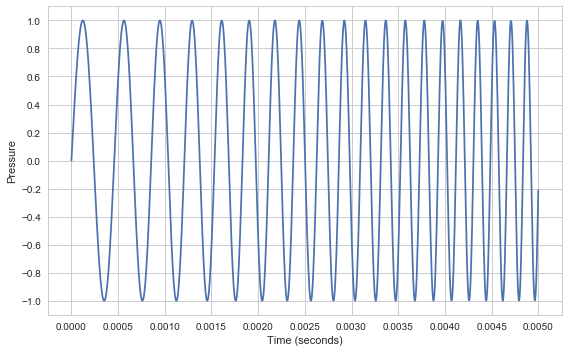

In [18]:
tone_data = linear_chirp_tone(2000, 6000, 0.005, sample_rate=sample_rate*4)
tone_data = normalize_data(tone_data)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.linspace(0, 0.005, num=math.ceil(0.005*sample_rate*4)),
        tone_data)

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Pressure")

ax.xaxis.set_major_locator(MultipleLocator(0.0005))
ax.yaxis.set_major_locator(MultipleLocator(0.2))

#ax.legend()
plt.tight_layout()
fig.savefig(output_data_directory+"/plot-linear_chirp_tone.pdf", dpi=300)
plt.show()

## Filters

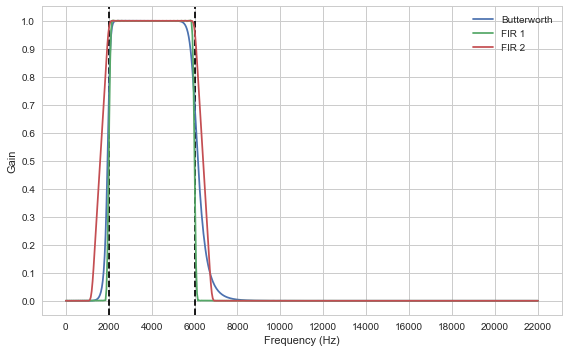

In [19]:
# Plot the frequency response for a few different filters and parameters.
fig, ax = plt.subplots(figsize=(8,5))

low_cut_frequency = 2000
high_cut_frequency = 6000
passband_stopband_edge = (high_cut_frequency-low_cut_frequency)*0.2
max_passband_loss=3
min_stopband_attenuation=20

ax.axvline(low_cut_frequency, color='black', linestyle="--") # low cutoff frequency
ax.axvline(high_cut_frequency, color='black', linestyle="--") # high cutoff frequency

nyquist_frequency = sample_rate/2
N, Wn = signal.buttord([low_cut_frequency/nyquist_frequency,
                        high_cut_frequency/nyquist_frequency],
                       [(low_cut_frequency-passband_stopband_edge)/nyquist_frequency,
                        (high_cut_frequency+passband_stopband_edge)/nyquist_frequency], 
                       max_passband_loss,
                       min_stopband_attenuation,
                       False)

b, a = butter(N, Wn, btype="band")
w, h = freqz(b, a)
ax.plot((nyquist_frequency/np.pi) * w, abs(h), label="Butterworth", linestyle="-")

fir_order = 500
a = [1.0]
b = firwin(fir_order,
           [low_cut_frequency,
            high_cut_frequency],
           nyq=nyquist_frequency,
           pass_zero=False)
w, h = freqz(b, a)
ax.plot((nyquist_frequency/np.pi) * w, abs(h), label="FIR 1", linestyle="-")

b = signal.firwin2(fir_order,
                   [0.0,
                    (low_cut_frequency-passband_stopband_edge)/nyquist_frequency,
                    low_cut_frequency/nyquist_frequency,
                    high_cut_frequency/nyquist_frequency,
                    (high_cut_frequency+passband_stopband_edge)/nyquist_frequency,
                    1.0],
                   [0.0, 0.0, 1.0, 1.0, 0.0, 0.0])
w, h = freqz(b, a)
ax.plot((nyquist_frequency/np.pi) * w, abs(h), label="FIR 2", linestyle="-")

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Gain')

ax.xaxis.set_major_locator(MultipleLocator(2000))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.legend()

fig.tight_layout()
plt.show()

## Helper Functions

In [20]:
def generate_tone(tone_frequency0, 
                  tone_frequency1,
                  tone_duration,
                  sample_rate,
                  filter_type,
                  filter_order,
                  save=True,
                  normalize=True,
                  path=input_data_directory+"/audio/tone.wav"):
    tone_data = linear_chirp_tone(tone_frequency0, tone_frequency1, tone_duration, sample_rate)
    if save:
        wavfile.write(path, sample_rate, tone_data.astype(np.int16))
    if(normalize):
        data = normalize_data(tone_data)
    else:
        data = tone_data    
    return filter_data(data,
                       tone_frequency0,
                       tone_frequency1,
                       filter_type=filter_type,
                       filter_order=filter_order)

def load_sample(path,
                tone_frequency0,
                tone_frequency1,
                filter_type,
                filter_order,
                normalize=True):
    sample_rate, sample_data = wavfile.read(path)
    if(normalize):
        data = normalize_data(sample_data)
    else:
        data = sample_data
    return sample_rate, filter_data(data,
                                    tone_frequency0,
                                    tone_frequency1,
                                    filter_type=filter_type,
                                    filter_order=filter_order)
   
def tone_correlation(sample_data, tone_frequency0, tone_frequency1, tone_data):
    correlation = sp.correlate(sample_data, tone_data, "valid")
    return correlation

def tone_recognition(sample_data, sample_rate, duration):
    last_index = 0
    tones = []
    tone_candidates = argrelmax(sample_data, order=math.ceil(duration*sample_rate/2))[0]
    for candidate in tone_candidates:
        tones.append((candidate, sample_data[candidate]))
    tones.sort(key=lambda tup: tup[1])
    tones.reverse()
    
    return tones

def compute_etoa(tones, sample_rate):
    if len(tones) < 2:
        raise NameError("Insufficient Tones Detected")
    else:
        return abs(tones[0][0]-tones[1][0])/sample_rate
    
def compute_distance(etoa_a, etoa_b, d_aa, d_bb, c=340.29):
    return (c/2) * (etoa_a - etoa_b) + (d_aa + d_bb)

def device_distance(self_distance_a,
                    self_distance_b,
                    device_a_path,
                    device_b_path,
                    tone_frequency0,
                    tone_frequency1,
                    tone_duration,
                    sample_rate,
                    sample_filter_type=None,
                    sample_filter_order=None,
                    tone_filter_type=None,
                    tone_filter_order=None,
                    normalize_tone=True,
                    normalize_samples=True,
                    verbose=False):

    tone_data = generate_tone(tone_frequency0,
                              tone_frequency1,
                              tone_duration,
                              sample_rate,
                              tone_filter_type,
                              tone_filter_order,
                              normalize=normalize_tone)
    if verbose:
        plt.figure()
        plt.plot(tone_data)
    
    
    if verbose:
        print("Device A Sample:", device_a_path)
        print("Device B Sample:", device_b_path)
    
    
    device_a_sample_rate, device_a_sample_data = load_sample(device_a_path,
                                                             tone_frequency0,
                                                             tone_frequency1,
                                                             sample_filter_type,
                                                             sample_filter_order,
                                                             normalize=normalize_samples)
    if verbose:
        plt.figure()
        plt.suptitle("Device A Waveform", fontsize=16)
        plt.plot(device_a_sample_data)
    
    device_b_sample_rate, device_b_sample_data = load_sample(device_b_path,
                                                             tone_frequency0,
                                                             tone_frequency1,
                                                             sample_filter_type,
                                                             sample_filter_order,
                                                             normalize=normalize_samples)
    if verbose:
        plt.figure()
        plt.suptitle("Device B Waveform", fontsize=16)
        plt.plot(device_b_sample_data)
    
    
    device_a_correlation = tone_correlation(device_a_sample_data,
                                            tone_frequency0,
                                            tone_frequency1,
                                            tone_data)
    if verbose:
        plt.figure()
        plt.suptitle("Device A Correlation", fontsize=16)
        plt.plot(device_a_correlation)
    
    device_b_correlation = tone_correlation(device_b_sample_data,
                                            tone_frequency0,
                                            tone_frequency1,
                                            tone_data)
    if verbose:
        plt.figure()
        plt.suptitle("Device B Correlation", fontsize=16)
        plt.plot(device_b_correlation)
    
    
    device_a_tones = tone_recognition(device_a_correlation, sample_rate, tone_duration)
    if verbose:
        print("Device A")
        print("A total of",len(device_a_tones),"tones were detected.")
        print("The best candidates are (",
              device_a_tones[0][0],",",device_a_tones[0][1],") and (",
              device_a_tones[1][0],",",device_a_tones[1][1],")")  
        print("A total of",len(device_a_tones),"tones were detected.")    
    
    device_b_tones = tone_recognition(device_b_correlation, sample_rate, tone_duration)
    if verbose: 
        print("Device B")
        print("The best candidates are (",
              device_b_tones[0][0],",",device_b_tones[0][1],") and (",
              device_b_tones[1][0],",",device_b_tones[1][1],")")  
        print("A total of",len(device_b_tones),"tones were detected.")
    
    
    etoa_a = compute_etoa(device_a_tones, sample_rate)
    if verbose: 
        print("Device A ETOA:",device_a_etoa)
        
    etoa_b = compute_etoa(device_b_tones, sample_rate)
    if verbose:
        print("Device B ETOA:",device_b_etoa)

    
    distance = compute_distance(etoa_a, etoa_b, self_distance_a, self_distance_b)
    if verbose:
        print("Distance between devices in meters:", distance)
    return distance

## Trials

In [21]:
self_distance_a = 0.04
self_distance_b = 0.04

trials = [
            {"actual_distance": 0.5,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-0-chirp-0.5m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-0-chirp-0.5m-db.wav"},
    
            {"actual_distance": 0.5,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-1-chirp-0.5m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-1-chirp-0.5m-db.wav"},
    
            {"actual_distance": 0.5,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-2-chirp-0.5m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-2-chirp-0.5m-db.wav"},
    
            {"actual_distance": 1,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-0-chirp-1m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-0-chirp-1m-db.wav"},
    
            {"actual_distance": 1,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-1-chirp-1m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-1-chirp-1m-db.wav"},
    
            {"actual_distance": 1,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-2-chirp-1m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-2-chirp-1m-db.wav"},
]

results = []
sample_filter_types = ["none", "buttord", "firwin", "firwin2"]
for trial in trials:
    for sample_filter_type in sample_filter_types:
        tone_filter_types = [sample_filter_type]
        for tone_filter_type in tone_filter_types:
            print("Trial Files:",trial["device_a_sample_path"], "and", trial["device_b_sample_path"])
            print("Actual distance between devices in meters:", trial["actual_distance"])
            estimated_distance = device_distance(trial["self_distance_a"],
                                                 trial["self_distance_b"],
                                                 trial["device_a_sample_path"],
                                                 trial["device_b_sample_path"],
                                                 tone_frequency0,
                                                 tone_frequency1,
                                                 tone_duration,
                                                 sample_rate,
                                                 sample_filter_type=sample_filter_type,
                                                 sample_filter_order=500,
                                                 tone_filter_type=tone_filter_type,
                                                 tone_filter_order=500,
                                                 verbose=False)
            print("Estimated distance between devices in meters:", estimated_distance)
            absolute_error = abs(estimated_distance-trial["actual_distance"])
            print("Absolute error:",absolute_error)
            relative_error = absolute_error/trial["actual_distance"]
            print("Relative error:", relative_error)
            results.append({"self_distance_a": trial["self_distance_a"],
                            "self_distance_b": trial["self_distance_b"],
                            "device_a_sample_path": trial["device_a_sample_path"],
                            "device_b_sample_path": trial["device_b_sample_path"],
                            "tone_frequency0": tone_frequency0,
                            "tone_frequency1": tone_frequency1,
                            "tone_duration": tone_duration,
                            "sample_rate": sample_rate,
                            "sample_filter_type": sample_filter_type,
                            "tone_filter_type": tone_filter_type,
                            "actual_distance": trial["actual_distance"],
                            "estimated_distance": estimated_distance,
                            "absolute_error": absolute_error,
                            "relative_error": relative_error})            
            print("--------------------")

Trial Files: data/audio/trial-0-chirp-0.5m-da.wav and data/audio/trial-0-chirp-0.5m-db.wav
Actual distance between devices in meters: 0.5
Estimated distance between devices in meters: 0.558412244898
Absolute error: 0.058412244898
Relative error: 0.116824489796
--------------------
Trial Files: data/audio/trial-0-chirp-0.5m-da.wav and data/audio/trial-0-chirp-0.5m-db.wav
Actual distance between devices in meters: 0.5
Estimated distance between devices in meters: 0.52368877551
Absolute error: 0.0236887755102
Relative error: 0.0473775510204
--------------------
Trial Files: data/audio/trial-0-chirp-0.5m-da.wav and data/audio/trial-0-chirp-0.5m-db.wav
Actual distance between devices in meters: 0.5
Estimated distance between devices in meters: 0.473532653061
Absolute error: 0.0264673469388
Relative error: 0.0529346938776
--------------------
Trial Files: data/audio/trial-0-chirp-0.5m-da.wav and data/audio/trial-0-chirp-0.5m-db.wav
Actual distance between devices in meters: 0.5
Estimated dis

In [22]:
columns = ["self_distance_a",
           "self_distance_b",
           "device_a_sample_path",
           "device_b_sample_path",
           "tone_frequency0",
           "tone_frequency1",
           "tone_duration",
           "sample_rate",
           "sample_filter_type",
           "tone_filter_type",
           "actual_distance",
           "estimated_distance",
           "absolute_error",
           "relative_error"]

results_table = pd.DataFrame.from_dict(results)[columns]
results_table.to_csv(output_data_directory+"/audio_estimated_distance_results.csv")
results_table

,self_distance_a,self_distance_b,device_a_sample_path,device_b_sample_path,tone_frequency0,tone_frequency1,tone_duration,sample_rate,sample_filter_type,tone_filter_type,actual_distance,estimated_distance,absolute_error,relative_error
0,0.04,0.04,data/audio/trial-0-chirp-0.5m-da.wav,data/audio/trial-0-chirp-0.5m-db.wav,2000,6000,0.05,44100,none,none,0.5,0.558412,0.058412,0.116824
1,0.04,0.04,data/audio/trial-0-chirp-0.5m-da.wav,data/audio/trial-0-chirp-0.5m-db.wav,2000,6000,0.05,44100,buttord,buttord,0.5,0.523689,0.023689,0.047378
2,0.04,0.04,data/audio/trial-0-chirp-0.5m-da.wav,data/audio/trial-0-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin,firwin,0.5,0.473533,0.026467,0.052935
3,0.04,0.04,data/audio/trial-0-chirp-0.5m-da.wav,data/audio/trial-0-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin2,firwin2,0.5,0.473533,0.026467,0.052935
4,0.04,0.04,data/audio/trial-1-chirp-0.5m-da.wav,data/audio/trial-1-chirp-0.5m-db.wav,2000,6000,0.05,44100,none,none,0.5,0.488965,0.011035,0.022069
5,0.04,0.04,data/audio/trial-1-chirp-0.5m-da.wav,data/audio/trial-1-chirp-0.5m-db.wav,2000,6000,0.05,44100,buttord,buttord,0.5,0.554554,0.054554,0.109108
6,0.04,0.04,data/audio/trial-1-chirp-0.5m-da.wav,data/audio/trial-1-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin,firwin,0.5,0.504398,0.004398,0.008796
7,0.04,0.04,data/audio/trial-1-chirp-0.5m-da.wav,data/audio/trial-1-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin2,firwin2,0.5,0.504398,0.004398,0.008796
8,0.04,0.04,data/audio/trial-2-chirp-0.5m-da.wav,data/audio/trial-2-chirp-0.5m-db.wav,2000,6000,0.05,44100,none,none,0.5,0.431093,0.068907,0.137814
9,0.04,0.04,data/audio/trial-2-chirp-0.5m-da.wav,data/audio/trial-2-chirp-0.5m-db.wav,2000,6000,0.05,44100,buttord,buttord,0.5,0.431093,0.068907,0.137814


In [31]:
results_table.groupby(["sample_filter_type"])["absolute_error"].describe()

,count,mean,std,min,25%,50%,75%,max
sample_filter_type,,,,,,,,
buttord,6.0,0.048610,0.035290,0.001757,0.027851,0.047446,0.065319,0.102413
firwin,6.0,0.023938,0.026354,0.001757,0.002417,0.015433,0.039765,0.065049
firwin2,6.0,0.023938,0.026354,0.001757,0.002417,0.015433,0.039765,0.065049
none,6.0,0.052931,0.038981,0.001757,0.022879,0.063660,0.073523,0.102413
